I will now work on problem 2.44 from Taylor, where we're given a drag force that depends on height due to variations in air density in the atmosphere do to height. Here we have the drag force $f(v, y) = \gamma D^2 e^{-y/\lambda}v^2$, $\lambda \approx 10,000$ m. The diameter of the cannonball is $D = 0.15 m$, its density is $7.8 \text{ g/cm}^3$, $\gamma = 0.25 \text{ Ns}^2/\text{m}^4$. 

The equations of motion are: 

\begin{align*}
m \dot{\mathbf{v}} &= m\mathbf{g} - \gamma D^2 e^{-y/\lambda}v^2 \hat{\mathbf{v}} \\
&= m\mathbf{g} - \gamma D^2 e^{-y/\lambda}v \mathbf{v}
\end{align*}

It follows that  

\begin{align*}
m \dot{v}_x &= - \gamma D^2 e^{-y/ \lambda}v v_x \\
m \dot{v}_y &= -mg - \gamma D^2 e^{-y/ \lambda}v v_y
\end{align*}

To solve this, we let the state function be 

\begin{align*}
\mathbf{q} = 
\begin{pmatrix}
x \\
\dot{x}\\
y \\
\dot{y}
\end{pmatrix}
\end{align*}

so that 

\begin{align*}
\dot{\mathbf{q}}(\dot{x}, \dot{y}, y, t) = 
\begin{pmatrix}
\dot{x} \\
\ddot{x}\\
\dot{y} \\
\ddot{y}
\end{pmatrix}
&= 
\begin{pmatrix}
\dot{x}\\
-\frac{\gamma}{m} D^2 e^{-y/ \lambda} \sqrt{\dot{x}^2+\dot{y}^2} \dot{x} \\
\dot{y}\\
-g -\frac{\gamma}{m} D^2 e^{-y/ \lambda}\sqrt{\dot{x}^2+\dot{y}^2} \dot{y}
\end{pmatrix} \\
&= A \mathbf{q} + \mathbf{q}^T\mathbf{p} + \mathbf{g}
\end{align*}

where we let 

\begin{align*}
A &= 
\begin{pmatrix}
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 
\end{pmatrix} \\
\mathbf{p}&= -\frac{\gamma}{m} D^2 e^{-y/ \lambda}\sqrt{\dot{x}^2+\dot{y}^2} \dot{y} 
\begin{pmatrix}
0 \\
1 \\ 
0 \\
1
\end{pmatrix}\\

\mathbf{g} &= -g
\begin{pmatrix}
0 \\ 0 \\ 0 \\ 1
\end{pmatrix}

\end{align*}

Here we will be expressing the velocities in terms of the launch angle $\theta$ and a velocity $v$. Where $v_x = v \cos \theta$ and $v_y = v \sin \theta$.

In [75]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import ipywidgets as wd
import matplotlib.animation as animation
%matplotlib widget


"""
The code used here I developed in a different notebook:
"2d_projectile_motion_quadratic_drag.ipynb"
"""

def stateFunction(t, vstar, beta, g, m):
    vx, vy = vstar # unpack the state vector components
    vxDot = -(beta/m)*np.sqrt(vx**2 + vy**2)*vx #calculate derivative in x
    vyDot = -g - (beta/m)*np.sqrt(vx**2 + vy**2)*vy # calculate derivative in y 
    return [vxDot, vyDot] #return answer as list

def stateFunctionExp(t, qstar, g, beta, lam):
    x, vx, y, vy = qstar
    xdot = vx
    ydot = vy
    vxdot = -beta*np.exp(-y/lam)*np.sqrt(xdot**2+ydot**2)*xdot
    vydot = -g-beta*np.exp(-y/lam)*np.sqrt(vx**2+vy**2)*ydot

    return [xdot, vxdot, ydot, vydot]

def integrateVelocity(t, vel, r0):
    x0, y0 = r0 #unpack initial position
    vx, vy = vel #unpack velocity array

    #integrate the velocity wrt time to determine position
    xOfT = sc.integrate.cumulative_simpson(vx, x=t, initial=x0)
    yOfT = sc.integrate.cumulative_simpson(vy, x=t, initial=y0)

    return [xOfT, yOfT] #return answer as list

def solve(t, fun, q0, args):
    #args contains the coefficients for the state function 
    
    #qstar needs to be the function that determines the derivative (stateFunction above)
    t_span = (t[0], t[-1]) #define the range of time based on t array
    #numerically solve given initial conditions 
    sol = sc.integrate.solve_ivp(fun, t_span, q0,
                                 method='RK45', t_eval=t,
                                 args=args)
    
    solution = [t] #create a list for the solution
    #unpack the solution vector to return as a tuple
    for y in sol.y:
        solution.append(y)
    
    return solution

def dragless(t, p):
    # p is the parameters for equation 1 above, t is an array for time
    # this will also calculate the velocities as functions of time
    
    v0 = p[5]
    phi = p[2]
    x = p[3] + np.cos(phi) * v0 * t
    y = p[4] + np.sin(phi) * v0 * t - 0.5 * p[0]*t**2
    vx = v0 * np.cos(phi) * np.ones(len(t))
    vy = v0 * np.sin(phi) - p[0] * t
    return [x, y, vx, vy]

def linDrag(t, p):
    g, m, tau, theta, x0, y0, v0 = p
    phi = theta*np.pi/180
    vy0 = np.sin(phi)*v0
    vx0 = np.cos(phi)*v0
    vter = tau*g

    vx = vx0*np.exp(-t/tau)
    vy = vy0*np.exp(-t/tau) + vter*(1-np.exp(-t/tau))

    x = vx0*tau*(1-np.exp(-t/tau))
    y = (vy0 + vter)*tau*(1-np.exp(-t/tau)) - vter*t

    yx = x * (vy0 + vter)/vx0 + vter * tau * np.log(1 - x/(vx0*tau))

    return [x, y, vx, vy, yx]

In [72]:
"""
To solve this problem, we will analyze no drag, 
simple quadratic drag, and quadratic drag with varying 
coefficient as a function of height. The first two instances
will be taken from the code developed in 
"2d_projectile_motion_quadratic_drag.ipynb". The third instance
will be done using the rk4Exp function above. 

In this cell I will just calculate everything. The next one
contains graphing code.
"""

#define important variables

g = 9.8 #m/s2
D = 0.15 #m, diameter
r = D/2 #radius of ball
V = (4/3)*np.pi*r**3 # volume of ball
rho = 7.8e3 #density of iron, in kg/m3
m = rho*V #mass of cannonball, in kg
gamma = 0.25 #Ns2/m4, quadratic drag coefficient

beta = (gamma/m)*D**2 #drag coefficient for equation
lam = 1e4 #m
theta = (50/180)*np.pi #initial angle of launch, in rad
v0 = 300 #m/s, initial velocity
x0, vx0, y0, vy0 = 0, v0*np.cos(theta), 0, v0*np.sin(theta)
q0 = np.array([
    x0, vx0, y0, vy0
])
v0arr = np.array([vx0, vy0])

paramsNoDrag = [g, m, theta, x0, y0, v0]
paramsQuadDrag = [gamma, g, m]
paramsExp = [g, beta, lam]

h = 0.001
N = 10000 #number of time steps
tStart = 0
tEnd = 3.5

t = np.arange(tStart, tEnd, h)

xDL, yDL, vxDL, vyDL = dragless(t, paramsNoDrag)
_, vxQ, vyQ = solve(t, stateFunction, v0arr, paramsQuadDrag)

vQ = [vxQ, vyQ]
xQ, yQ = integrateVelocity(t, vQ, r0=[x0, y0])

_, xExp, vxExp, yExp, vyExp = solve(t, stateFunctionExp, q0, paramsExp)


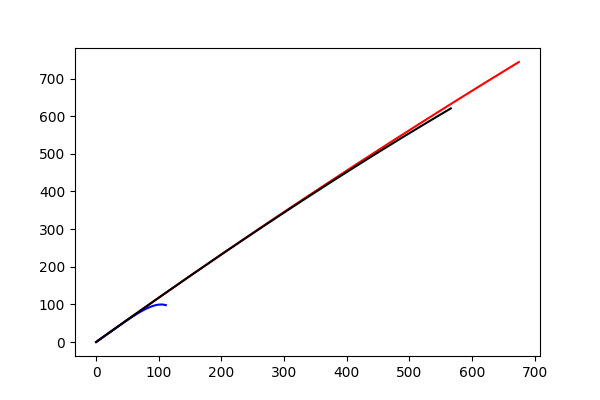

In [74]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(xDL, yDL, label='No Drag', color='r')
ax.plot(xQ, yQ, label='Quadratic Drag', color='b')
ax.plot(xExp, yExp, label='Varying Quadratic Drag', color='k')